# 1. Generate data

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import eig

import random

from scipy.sparse.csgraph import laplacian
from scipy.stats import bernoulli

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans 

import time


from simulate import *

In [2]:
n = 1000
m = 30
N = n + m
r = 2
p = 0.29
q = 0.11

In [3]:
# Generate group labels, group "2" is outlier
phi_ordered_o = [0] * int(n / 2) + [1] * int(n / 2) + [2] * int(m)
#phi_o = [i for i in random.sample(phi_ordered_o, n)]
phi_o = phi_ordered_o

In [4]:
# Generate connectivity matrix B
B_in = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        if phi_o[i] == phi_o[j]:
            B_in[i, j] = p
        else:
            B_in[i, j] = q
B_in = B_in + B_in.transpose()

In [5]:
K = conn2adj(B_in)

# Generate adjacdncy matrix W for outliers
B_out = np.full((m, m), .7) - .7 * np.eye(m)

W = conn2adj(B_out)

# Generate Z
beta = np.random.uniform(low =  0, high= 1, size = n)
beta = beta ** 2
EZ = np.tile(beta, (m, 1)).transpose()

Z = np.zeros((n, m))
for idx, z in np.ndenumerate(EZ):
    #print(idx, z)
    Z[idx] = bernoulli.rvs(size = 1, p = z)
    
    
# Combine K, Z and W to be A
A_combined = np.concatenate((K, Z), axis = 1)
bottom = np.concatenate((Z.transpose(), W), axis = 1)
A_combined = np.concatenate((A_combined, bottom), axis = 0)

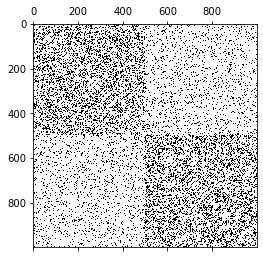

In [6]:
plt.matshow(K, cmap = plt.cm.binary)

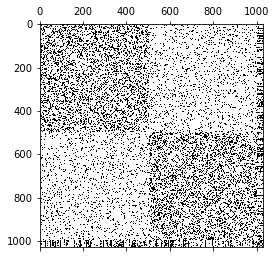

In [7]:
plt.matshow(A_combined, cmap = plt.cm.binary)

# 2. Algorithm 2

In [8]:
Z = 0
Lambda = 0
rho = 1
max_iter = 100
alpha = 0

# choose lambda
degrees = np.mean(A_combined, axis = 0)
trimmed = degrees[(degrees >= np.quantile(degrees, 0.2)) & (degrees <= np.quantile(degrees, 0.8))]
lam = np.mean(trimmed)

In [9]:
E = alpha * np.eye(N) - (1 - lam) * A_combined + lam * (np.full((N, N), 1) - np.eye(N) - A_combined)

In [10]:
k = 0
time.start = time.time()
while k < max_iter:
    if k % 10 == 0:
        print("k = ", k, time.time() - time.start, "\n")
    # 1. Update Y ========
    
    X = Z - Lambda - E / rho
    X_values, V = eig(X)

    X_values_plus = X_values * (X_values > 0)
    Sigma_plus = np.zeros((N, N))
    np.fill_diagonal(Sigma_plus, X_values_plus)

    X_plus = V @ Sigma_plus @ V.transpose()
    Y = X_plus
    
    # 2. Update Z ========
    inside = (Y + Lambda) * (Y + Lambda > 0)
    Z = inside * (inside > 1) +  np.full((N, N), 1) * (inside <= 1)
    
    # 3. Update Lambda ========
    Lambda = Lambda + (Y - Z)
    
    k += 1

k =  0 0.00011587142944335938 

k =  10 44.66993999481201 

k =  20 88.84597587585449 

k =  30 132.0752809047699 

k =  40 177.1858937740326 

k =  50 215.07628893852234 

k =  60 255.12100291252136 

k =  70 299.26465678215027 

k =  80 339.4773008823395 

k =  90 381.33918380737305 



In [11]:
Xhat = Y
Xhat_normalized = normalize(Xhat, axis = 1, norm = 'l2')

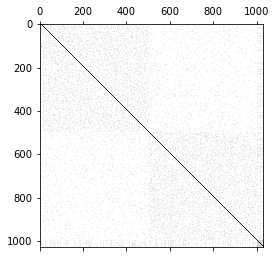

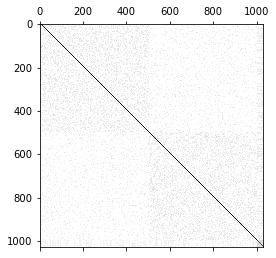

In [12]:
plt.matshow(Xhat, cmap = plt.cm.binary)
plt.matshow(Xhat_normalized, cmap = plt.cm.binary)

In [13]:
def cal_mis_rate(y, yhat):
    rate = np.mean(abs(y - yhat))
    return min(rate, 1 - rate)

In [14]:
yhat_list = []
mis_rates = []

mis_rates_inlier = []
for seed in range(100):
    kmeans = KMeans(n_clusters = 2, random_state = seed).fit(Xhat)
    yhat = kmeans.labels_
    yhat_list = yhat_list + [yhat]
    
    mis_rate = cal_mis_rate(phi_o, yhat)
    mis_rates = mis_rates + [mis_rate]
    
    mis_rate_inlier = cal_mis_rate(phi_o[:n], yhat[:n])
    mis_rates_inlier = mis_rates_inlier + [mis_rate_inlier]
    
    print("seed = ", seed, "mis rate inlier = ", mis_rate_inlier)

seed =  0 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  1 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  2 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  3 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  4 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  5 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  6 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  7 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  8 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  9 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  10 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  11 mis rate inlier =  0.0 , mis rate =  -0.029126213592232997 

seed =  12 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  13 mis rate inlier =  0.0 , mis rate =  0.02912621359223301 

seed =  14 mis rat

In [15]:
print("Averaged misclassification rate of inliers is ", np.mean(mis_rates_inlier), ", \n",
     "Averaged misclassification rate for all nodes is ", np.mean(mis_rates))

Averaged misclassification rate of inliers is  0.0 , 
 Averaged misclassification rate for all nodes is  -0.0005825242718446533
